# Import Data in Pytorch

## Preparation

In [3]:
#Full cell width
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [4]:
import pandas as pd
import numpy as np

We are going to use the unrolled dataset created in [data_conversion](http://localhost:8889/notebooks/data_conversion.ipynb). 
<br>
To save some computational effort, we are using only a subsample of this dataset consisting of 100 cases here.

In [5]:
#use unrolled dataset created in "data_conversion"-notebook
dataset = pd.read_json("allImages_unfolded.json", orient="split")

In [6]:
# create sample dataset with 100 randomly chosen entries of the original dataset
rand_indexes = np.random.randint(0, len(dataset)+1, 100)
sampleset = dataset.loc[rand_indexes, :]
# indexes from 0 - 100
sampleset = sampleset.set_index(np.array(range(len(sampleset))))

The sampledataset is stored on the disk, so that it can be imported from this file directly by pytorch.

In [7]:
#orient="split" stores index and column information in lists, to keep the order of the df
sampleset.to_json("allImages_unfolded_sampleset.json", orient="split")

In [8]:
sampleset.head()

,filename,category,impath,trial,recording_session_label,sinit,SDT,fixations
0,sun_becrzqbttylkmgmc.jpg,dining_room,Fillers/dining_room/sun_becrzqbttylkmgmc.jpg,1064.0,dd_14_2,dd,"[[2, -1, -1]]","[[502.7, 506.3], [447.8, 528.5], [596.1, 355.3..."
1,sun_abmwkkexqzjttlyv.jpg,lighthouse,Fillers/lighthouse/sun_abmwkkexqzjttlyv.jpg,1070.0,mm_5_1,mm,"[[4, -1, -1]]","[[491.6, 455.1], [340.8, 319.1], [548.2, 486.8..."
2,sun_alcrgfmnthjmdeew.jpg,golf_course,Fillers/golf_course/sun_alcrgfmnthjmdeew.jpg,1070.0,gc_13_1,gc,"[[4, -1, -1]]","[[508.9, 501.9], [460.2, 536.6], [699.3, 471.5..."
3,sun_bxuplberboeawncp.jpg,pasture,Fillers/pasture/sun_bxuplberboeawncp.jpg,1063.0,sl_13_3,sl,"[[4, -1, -1]]","[[505.3, 550.1], [508.1, 644.3], [457.2, 748.5..."
4,sun_akxcpkquuuxdiqwv.jpg,kitchen,Fillers/kitchen/sun_akxcpkquuuxdiqwv.jpg,1063.0,sl_13_3,sl,"[[4, -1, -1]]","[[509.5, 529.1], [541.6, 591.3], [364.4, 655.8..."


## Data Loading and Preprocessing Tutorial

We use [this](https://pytorch.org/tutorials/beginner/data_loading_tutorial.html#sphx-glr-download-beginner-data-loading-tutorial-py) tutorial adapted to our dataset of images and fixations.

In [9]:
from __future__ import print_function, division
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

plt.ion()   # interactive mode

For some image fixated by one subject, store the image name, the image category and the fixations.

In [14]:
n = 2
img_name = sampleset.iloc[n, 0]
img_cat = sampleset.iloc[n, 1]
fixations = np.array(sampleset.iloc[n, 7])

print('Image name: {}'.format(img_name))
print('Image category: {}'.format(img_cat))
print('Fixation shape: {}'.format(fixations.shape))
print('First 4 Fixations: {}'.format(fixations[:4]))

Image name: sun_alcrgfmnthjmdeew.jpg
Image category: golf_course
Fixation shape: (8, 2)
First 4 Fixations: [[508.9 501.9]
 [460.2 536.6]
 [699.3 471.5]
 [763.6 382. ]]


Use a helper function to show an image and its fixations and use it to show the sample selected above (image number {{n}}).

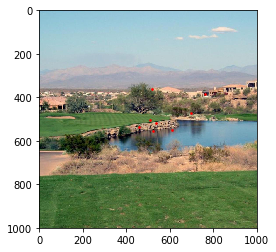

In [18]:
def show_fixations(image, fixations):
    """Show image with fixations"""
    plt.imshow(image)
    plt.scatter(fixations[:, 0], fixations[:, 1], s=10, marker='.', c='r')
    plt.pause(0.001)  # pause a bit so that plots are updated

plt.figure()
show_fixations(io.imread(os.path.join('figrim/fillerData/Fillers/' + img_cat + '/', img_name)),
               fixations)
plt.show()

### Dataset Class

``torch.utils.data.Dataset`` is an abstract class representing a
dataset.
Your custom dataset should inherit ``Dataset`` and override the following
methods:

-  ``__len__`` so that ``len(dataset)`` returns the size of the dataset.
-  ``__getitem__`` to support the indexing such that ``dataset[i]`` can
   be used to get $i$\ th sample

Let's create a dataset class for our face landmarks dataset. We will
read the csv in ``__init__`` but leave the reading of images to
``__getitem__``. This is memory efficient because all the images are not
stored in the memory at once but read as required.

Sample of our dataset will be a dict
``{'image': image, 'landmarks': landmarks}``. Our datset will take an
optional argument ``transform`` so that any required processing can be
applied on the sample. We will see the usefulness of ``transform`` in the
next section.




In [16]:
class FigrimFillersDataset(Dataset):
    """Figrim fillers dataset."""

    def __init__(self, json_file, root_dir, transform=None):
        """
        Args:
            json_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        #use orient="split" on storing and reading
        self.figrim_frame = pd.read_json(json_file, orient="split")
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.figrim_frame)

    def __getitem__(self, idx):
        img_name = sampleset.iloc[idx, 0]
        img_cat = sampleset.iloc[idx, 1]
        img_path = os.path.join(self.root_dir + '/' + img_cat + '/', img_name)
        image = io.imread(img_path)
        fixations = np.array(sampleset.iloc[idx, 7])
        sample = {'image': image, 'fixations': fixations}

        if self.transform:
            sample = self.transform(sample)

        return sample

Let's instantiate this class and iterate through the data samples. We
will print the sizes of first 4 samples and show their landmarks.




0 (1000, 1000, 3) (8, 2)


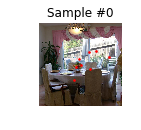

1 (1000, 1000, 3) (7, 2)


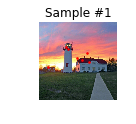

2 (1000, 1000, 3) (8, 2)


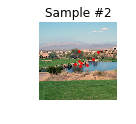

3 (1000, 1000, 3) (9, 2)


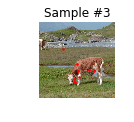

In [17]:
figrim_dataset = FigrimFillersDataset(json_file='allImages_unfolded_sampleset.json',
                                    root_dir='figrim/fillerData/Fillers')

fig = plt.figure()

for i in range(len(figrim_dataset)):
    sample = figrim_dataset[i]

    print(i, sample['image'].shape, sample['fixations'].shape)

    ax = plt.subplot(1, 4, i + 1)
    plt.tight_layout()
    ax.set_title('Sample #{}'.format(i))
    ax.axis('off')
    show_fixations(**sample) #expand the dict "sample" into separate elements

    if i == 3:
        plt.show()
        break

### Transforms


One issue could be that the samples are not of the
same size. Most neural networks expect the images of a fixed size.
Therefore, if that were the case, we would need to write some prepocessing code.
Let's create three transforms:

-  ``Rescale``: to scale the image
-  ``RandomCrop``: to crop from image randomly. This is data
   augmentation.
-  ``ToTensor``: to convert the numpy images to torch images (we need to
   swap axes).

We will write them as callable classes instead of simple functions so
that parameters of the transform need not be passed everytime it's
called. For this, we just need to implement ``__call__`` method and
if required, ``__init__`` method. We can then use a transform like this:

::

    tsfm = Transform(params)
    transformed_sample = tsfm(sample)

Observe below how these transforms had to be applied both on the image and
fixations.

In [19]:
class Rescale(object):
    """Rescale the image in a sample to a given size.

    Args:
        output_size (tuple or int): Desired output size. If tuple, output is
            matched to output_size. If int, smaller of image edges is matched
            to output_size keeping aspect ratio the same.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        self.output_size = output_size

    def __call__(self, sample):
        image, fixations = sample['image'], sample['fixations']

        h, w = image.shape[:2]
        if isinstance(self.output_size, int):
            if h > w:
                new_h, new_w = self.output_size * h / w, self.output_size
            else:
                new_h, new_w = self.output_size, self.output_size * w / h
        else:
            new_h, new_w = self.output_size

        new_h, new_w = int(new_h), int(new_w)

        img = transform.resize(image, (new_h, new_w))

        # h and w are swapped for fixations because for images,
        # x and y axes are axis 1 and 0 respectively
        fixations = fixations * [new_w / w, new_h / h]

        return {'image': img, 'fixations': fixations}


class RandomCrop(object):
    """Crop randomly the image in a sample.

    Args:
        output_size (tuple or int): Desired output size. If int, square crop
            is made.
    """

    def __init__(self, output_size):
        assert isinstance(output_size, (int, tuple))
        if isinstance(output_size, int):
            self.output_size = (output_size, output_size)
        else:
            assert len(output_size) == 2
            self.output_size = output_size

    def __call__(self, sample):
        image, fixations = sample['image'], sample['fixations']

        h, w = image.shape[:2] #ersten beiden Dimensionen
        new_h, new_w = self.output_size

        top = np.random.randint(0, h - new_h)
        left = np.random.randint(0, w - new_w)

        image = image[top: top + new_h,
                      left: left + new_w]

        fixations = fixations - [left, top]

        return {'image': image, 'fixations': fixations}


class ToTensor(object):
    """Convert ndarrays in sample to Tensors."""

    def __call__(self, sample):
        image, fixations = sample['image'], sample['fixations']

        # swap color axis because
        # numpy image: H x W x C
        # torch image: C X H X W
        image = image.transpose((2, 0, 1))
        return {'image': torch.from_numpy(image),
                'fixations': torch.from_numpy(fixations)}

#### Compose transforms

Now, we apply the transforms on an sample.

Let's say we want to rescale the shorter side of the image to 256 and
then randomly crop a square of size 224 from it. i.e, we want to compose
``Rescale`` and ``RandomCrop`` transforms.
``torchvision.transforms.Compose`` is a simple callable class which allows us
to do this.




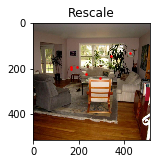

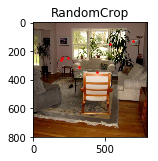

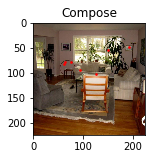

In [20]:
scale = Rescale(512)
crop = RandomCrop(800)
composed = transforms.Compose([Rescale(256),
                               RandomCrop(224)])

# Apply each of the above transforms on sample.
fig = plt.figure()
sample = figrim_dataset[65]
for i, tsfrm in enumerate([scale, crop, composed]):
    transformed_sample = tsfrm(sample)

    ax = plt.subplot(1, 3, i + 1)
    plt.tight_layout()
    ax.set_title(type(tsfrm).__name__)
    show_fixations(**transformed_sample)

plt.show()

### Iterating through the dataset

Let's put this all together to create a dataset with composed
transforms.
To summarize, every time this dataset is sampled:

-  An image is read from the file on the fly
-  Transforms are applied on the read image
-  Since one of the transforms is random, data is augmentated on
   sampling

We can iterate over the created dataset with a ``for i in range``
loop as before.




In [22]:
transformed_dataset = FigrimFillersDataset(json_file='allImages_unfolded_sampleset.json',
                                           root_dir='figrim/fillerData/Fillers',
                                           transform=transforms.Compose([
                                               Rescale(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['fixations'].size())

    if i == 3:
        break

0 torch.Size([3, 224, 224]) torch.Size([8, 2])
1 torch.Size([3, 224, 224]) torch.Size([7, 2])
2 torch.Size([3, 224, 224]) torch.Size([8, 2])
3 torch.Size([3, 224, 224]) torch.Size([9, 2])


#### DataLoader
However, we are losing a lot of features by using a simple ``for`` loop to
iterate over the data. In particular, we are missing out on:

-  Batching the data
-  Shuffling the data
-  Load the data in parallel using ``multiprocessing`` workers.

``torch.utils.data.DataLoader`` is an iterator which provides all these
features. Parameters used below should be clear. One parameter of
interest is ``collate_fn``. You can specify how exactly the samples need
to be batched using ``collate_fn``. However, default collate should work
fine for most use cases.




**This part of the tutorial's code does not work**
<br>
From googling the error: "looks like the Windows fork/spawn issue on Windows 10".
Solution proposed [here](https://discuss.pytorch.org/t/broken-pipe-for-data-loading-tutorial-on-windows10/19648) does not work.

In [30]:
dataloader = DataLoader(transformed_dataset, batch_size=4,
                    shuffle=True, num_workers=4)


# Helper function to show a batch
'''def show_fixations_batch(sample_batched):
    """Show image with fixations for a batch of samples."""
    images_batch, fixations_batch = \
            sample_batched['image'], sample_batched['fixations']
    batch_size = len(images_batch)
    im_size = images_batch.size(2)

    grid = utils.make_grid(images_batch)
    plt.imshow(grid.numpy().transpose((1, 2, 0)))

    for i in range(batch_size):
        plt.scatter(fixations_batch[i, :, 0].numpy() + i * im_size,
                    fixations_batch[i, :, 1].numpy(),
                    s=10, marker='.', c='r')

        plt.title('Batch from dataloader')

for i_batch, sample_batched in enumerate(dataloader):
    print(i_batch, sample_batched['image'].size(),
          sample_batched['fixations'].size())

    # observe 4th batch and stop.
    if i_batch == 3:
        plt.figure()
        show_landmarks_batch(sample_batched)
        plt.axis('off')
        plt.ioff()
        plt.show()
        break'''

'def show_fixations_batch(sample_batched):\n    """Show image with fixations for a batch of samples."""\n    images_batch, fixations_batch =             sample_batched[\'image\'], sample_batched[\'fixations\']\n    batch_size = len(images_batch)\n    im_size = images_batch.size(2)\n\n    grid = utils.make_grid(images_batch)\n    plt.imshow(grid.numpy().transpose((1, 2, 0)))\n\n    for i in range(batch_size):\n        plt.scatter(fixations_batch[i, :, 0].numpy() + i * im_size,\n                    fixations_batch[i, :, 1].numpy(),\n                    s=10, marker=\'.\', c=\'r\')\n\n        plt.title(\'Batch from dataloader\')\n\nfor i_batch, sample_batched in enumerate(dataloader):\n    print(i_batch, sample_batched[\'image\'].size(),\n          sample_batched[\'fixations\'].size())\n\n    # observe 4th batch and stop.\n    if i_batch == 3:\n        plt.figure()\n        show_landmarks_batch(sample_batched)\n        plt.axis(\'off\')\n        plt.ioff()\n        plt.show()\n        bre